## Fast and Agile Resnet34 with fast.ai and fastkaggle

During the amazing learning experience that was the fastai 2022 course -stay tuned because it will be released for free in a couple of weeks- and Jeremy's live coding sessions, we were guided in an experimenting journey using different models and applying multiple techniques.  
  
 
I found resnet34 to be great model for this dataset to experiment with. It is also a very light and fast model to run on my old 8Gb GPU. 
  
This Notebook became my baseline model from which I started to test all the techniques that were showed in Jeremy's "Road to the Top" series that are linked in the Acknowledgements.
  


### Acknowledgements

**fastai course:**
- [Practical Deep Learning for Coders (a UQ collaboration with fast.ai)](https://itee.uq.edu.au/event/2022/practical-deep-learning-coders-uq-fastai)  

**Jeremy's Notebook Series:**
- [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1)
- [Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2)
- [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3)
- [Multi-target: Road to the Top, Part 4](https://www.kaggle.com/code/jhoward/multi-target-road-to-the-top-part-4)

### Installing the libraries


In [1]:
# fastkaggle allows you to work locally and then submit the results and notebook to Kaggle

try: import fastkaggle

except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
competition = 'paddy-disease-classification'
path = setup_comp(competition, install='fastai "timm>=0.6.2.dev0"')

from fastai.vision.all import *
set_seed(42)

### Setting data paths

In [3]:
# train images
train_path = path / 'train_images'
train_files = get_image_files(train_path)

# test images
test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()

# sample submission
sample_submission = pd.read_csv(path/'sample_submission.csv')

# train labels
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


### Dataloaders for fastai training
You can create the dataloader in any of these two ways:
1. From a `DataBlock`

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

2. By using the high level `ImageDataLoaders`

In [5]:
"""dls = ImageDataLoaders.from_folder(
    train_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)"""

"dls = ImageDataLoaders.from_folder(\n    train_path, \n    valid_pct=0.2,\n    seed=42,\n    item_tfms=Resize(480, method='squish'),\n    batch_tfms=aug_transforms(size=224, min_scale=0.75)\n)"

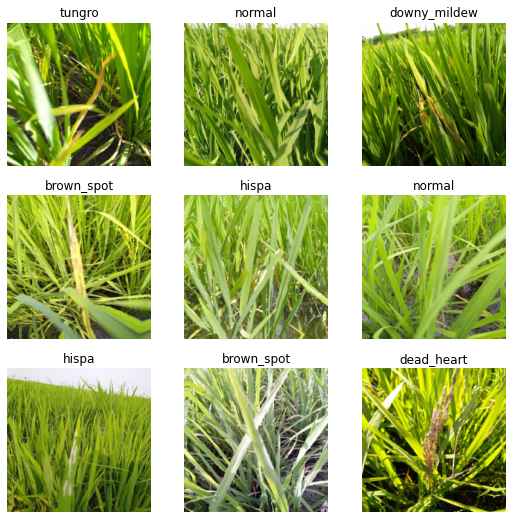

In [6]:
dls.show_batch()

### Create a learner and train

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

And that's it, 16 epochs to get the best baseline for the price 

In [8]:
learn.fine_tune(16, 0.005)

epoch,train_loss,valid_loss,error_rate,time
0,1.738740,0.982435,0.319558,01:27


epoch,train_loss,valid_loss,error_rate,time
0,0.742288,0.458268,0.141278,01:28


KeyboardInterrupt: 

### Predictions and Test Time Augmentation

Lets compare the error rate -on the validation set- that are obtained with the normal prediction function and with the predictions we can get applying a technique called Test Time Augmentation (TTA). As you'll see, TTA is easy with fastai.

In [9]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0255)

In [10]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0231)

So you can see a boost with TTA.

### Predictions on test set

In [11]:
# TTA predictions from test images
probs, _ = learn.tta(dl=dls.test_dl(test_files))

In [12]:
# get the index with the greater probability
preds = probs.argmax(dim=1)

In [13]:
dls.vocab[preds]

(#3469) ['hispa','normal','blast','blast','blast','brown_spot','dead_heart','brown_spot','hispa','normal'...]

### Submission

In [14]:
sample_submission.label = dls.vocab[preds]
sample_submission.to_csv('submission.csv', index=False)

### Conclusions

* I found this model being a good baseline, with a good accuracy for its speed and cost.
* You can try different epochs, learning rates, or even a different seed and see what happens when submitting the results.
* Then you can apply some of the techniques that Jeremy applied in his series.
* And keep trying.



In [15]:
# Pushing the notebook from my home PC to Kaggle

if not iskaggle:
    push_notebook(
        'fmussari', 
        'fast-resnet34-with-fastai',
        title='Fast Resnet34 with Fastai',
        file='2022-07. Fast and Agile Resnet34 with Fastai.ipynb',
        competition=competition, 
        private=True, 
        gpu=True
    )

Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/fmussari/fast-resnet34-with-fastai
